In [ ]:
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output


%matplotlib inline

In [ ]:
def generate_uniform_noise(batch_size):
  return torch.rand(batch_size,1)


In [ ]:
def generate_normal_noise(batch_size):
  return torch.randn(batch_size,1) + 5

In [ ]:
class Generator(nn.Module):
  def __init__(self):
    """Generator transforms the uniform distribution to normal distribution"""
    super().__init__()
    self.main=nn.Sequential(
        nn.Linear(in_features=1,out_features=16),
        nn.ReLU(), # to add non linearity
        nn.Linear(in_features=16,out_features=1)

    )
  def forward(self,x):
    return self.main(x)

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    """disc(x) returns probability of x to belong to real class"""
    super().__init__()
    self.main=nn.Sequential(
        nn.Linear(in_features=1,out_features=64),
        nn.ReLU(),
        nn.Linear(in_features=64,out_features=1),
        nn.Sigmoid() # to compute probability
    )
  def forward(self,x):
    return self.main(x)

In [ ]:
gen=Generator()
disc=Discriminator()

In [ ]:
generator_opt=torch.optim.SGD(gen.parameters(), lr=1e-3)
discriminator_opt=torch.optim.SGD(disc.parameters(), lr=1e-3)

In [ ]:
def update_D(batch_size):

  #1. Sample real data
  #2. Compute probability of real object to be real

  real_samples = generate_normal_noise(batch_size)
  prob_real_is_real=disc(real_samples)

  #1. Sample Noise
  #2.Obtain generated samples
  #3. Compute probability of fake objects to be fake

  noise=generate_uniform_noise(batch_size)
  generated_samples=gen(noise)
  prob_fake_is_fake=1-disc(generated_samples)



  # Compute loss
  # maximize prob of real class to be real and fake class to be fake

  loss=(-torch.log(prob_real_is_real)-torch.log(prob_fake_is_fake)).mean()


  # Make gradient step
  discriminator_opt.zero_grad()
  loss.backward()
  discriminator_opt.step()

  return loss.data.numpy().item()

In [ ]:
def update_G(batch_size):

  #1. Sample Noise
  #2.Obtain generated samples
  #3. Compute probability of fake objects to be fake

  noise=generate_uniform_noise(batch_size)
  generated_samples=gen(noise)
  prob_fake_is_real=disc(generated_samples)



  # Compute loss
  # maximize prob of real class to be real and fake class to be fake

  loss=(-torch.log(prob_fake_is_real)).mean()


  # Make gradient step
  generator_opt.zero_grad()
  loss.backward()
  generator_opt.step()

  return loss.data.numpy().item()

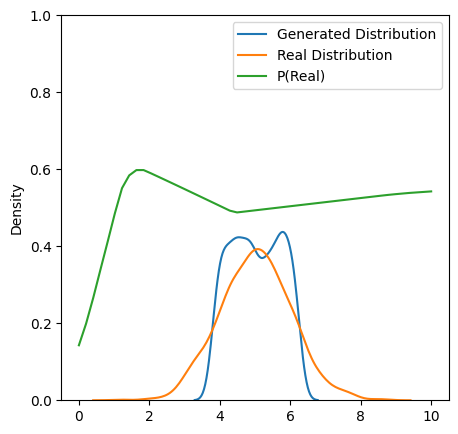

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-10-f37262962d32>", line 7, in <cell line: 5>
    update_D(BATCH_SIZE)
  File "<ipython-input-8-9c1d80b56a8b>", line 14, in update_D
    generated_samples=gen(noise)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1553, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1562, in _call_impl
    return forward_call(*args, **kwargs)
  File "<ipython-input-4-4e13ae680cef>", line 12, in forward
    return self.main(x)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line 1553, in _wrapped_call_impl
    return self._call_impl(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/torch/nn/modules/module.py", line

TypeError: object of type 'NoneType' has no len()

In [ ]:
N_DISC_OPERTAIONS=50 # No of updates for discriminator on each iteration

BATCH_SIZE=64

for i in range(10000):
  for _ in range(N_DISC_OPERTAIONS):
    update_D(BATCH_SIZE)

  update_G(BATCH_SIZE)

  if i%100 == 0:
    clear_output(True)
    plt.figure(figsize=[5,5])

    sns.kdeplot(gen(generate_uniform_noise(1000)).data.numpy()[:,0],label='Generated Distribution')
    sns.kdeplot(generate_normal_noise(1000).data.numpy()[:,0],label='Real Distribution')

    x=np.linspace(0,10,dtype='float32')
    p_real=disc(torch.from_numpy(x[:,None]))
    plt.plot(x,p_real.data.numpy(),label='P(Real)')

    axes=plt.gca()
    axes.set_ylim([0,1])

    plt.legend()
    plt.show()


# Dealing with a 2-D data generation

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output


%matplotlib inline

In [ ]:
# Generation of smaples from mixture of Gaussian distributions
mu1, sig1= [-5., -5.],1.
mu2, sig2= [5., 5.],1.
mu3, sig3= [-5., 5.],1.

NOISE_DIM=2 # Increase this for Generator to be able to approximate Input data distribution

In [ ]:
def generate_uniform_noise(batch_size):
  return torch.rand(batch_size,NOISE_DIM)


In [ ]:
def plot_2D_density(xy):
  cmap=sns.cubehelix_palette(light=3, as_cmap=True)
  sns.kdeplot(x=xy[:,0],y=xy[:,1],cut=5,label='pdata')

In [ ]:
def sample_real_data(batch_size):
  n1,n2=int(batch_size/3),int(batch_size/3)
  n3=batch_size-n1-n2
  data=np.vstack([
      np.random.normal(mu1,sig1,(n1,2)),
      np.random.normal(mu2,sig2,(n2,2)),
      np.random.normal(mu3,sig3,(n3,2))
  ])
  return torch.FloatTensor(data)

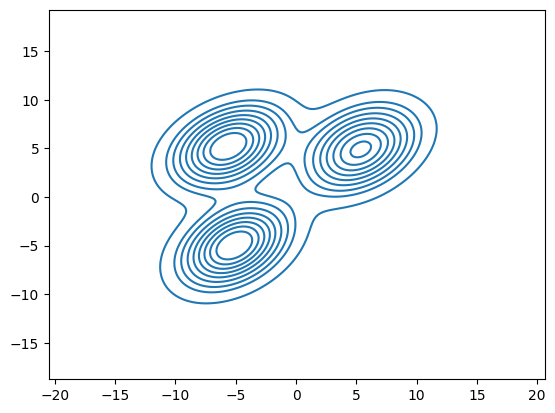

In [ ]:
plot_2D_density(sample_real_data(64).data.numpy())

In [ ]:
class Generator(nn.Module):
  def __init__(self):
    """Generator transforms the uniform distribution to normal distribution"""
    super().__init__()
    self.main=nn.Sequential(
        nn.Linear(in_features=NOISE_DIM,out_features=16),
        nn.ReLU(), # to add non linearity
        nn.Linear(in_features=16,out_features=2)

    )
  def forward(self,x):
    return self.main(x)

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    """disc(x) returns probability of x to belong to real class"""
    super().__init__()
    self.main=nn.Sequential(
        nn.Linear(in_features=2,out_features=64),
        nn.ReLU(),
        nn.Linear(in_features=64,out_features=1),
        nn.Sigmoid() # to compute probability
    )
  def forward(self,x):
    return self.main(x)

In [ ]:
gen=Generator()
disc=Discriminator()

In [ ]:
generator_opt=torch.optim.SGD(gen.parameters(), lr=1e-3)
discriminator_opt=torch.optim.SGD(disc.parameters(), lr=1e-3)

In [ ]:
def update_D(batch_size):

  #1. Sample real data
  #2. Compute probability of real object to be real

  real_samples = sample_real_data(batch_size)
  prob_real_is_real=disc(real_samples)

  #1. Sample Noise
  #2.Obtain generated samples
  #3. Compute probability of fake objects to be fake

  noise=generate_uniform_noise(batch_size)
  generated_samples=gen(noise)
  prob_fake_is_fake=1-disc(generated_samples)



  # Compute loss
  # maximize prob of real class to be real and fake class to be fake

  loss=(-torch.log(prob_real_is_real)-torch.log(prob_fake_is_fake)).mean()


  # Make gradient step
  discriminator_opt.zero_grad()
  loss.backward()
  discriminator_opt.step()

  return loss.data.numpy().item()

In [ ]:
def update_G(batch_size):

  #1. Sample Noise
  #2.Obtain generated samples
  #3. Compute probability of fake objects to be fake

  noise=generate_uniform_noise(batch_size)
  generated_samples=gen(noise)
  prob_fake_is_real=disc(generated_samples)



  # Compute loss
  # maximize prob of real class to be real and fake class to be fake

  loss=(-torch.log(prob_fake_is_real)).mean()


  # Make gradient step
  generator_opt.zero_grad()
  loss.backward()
  generator_opt.step()

  return loss.data.numpy().item()

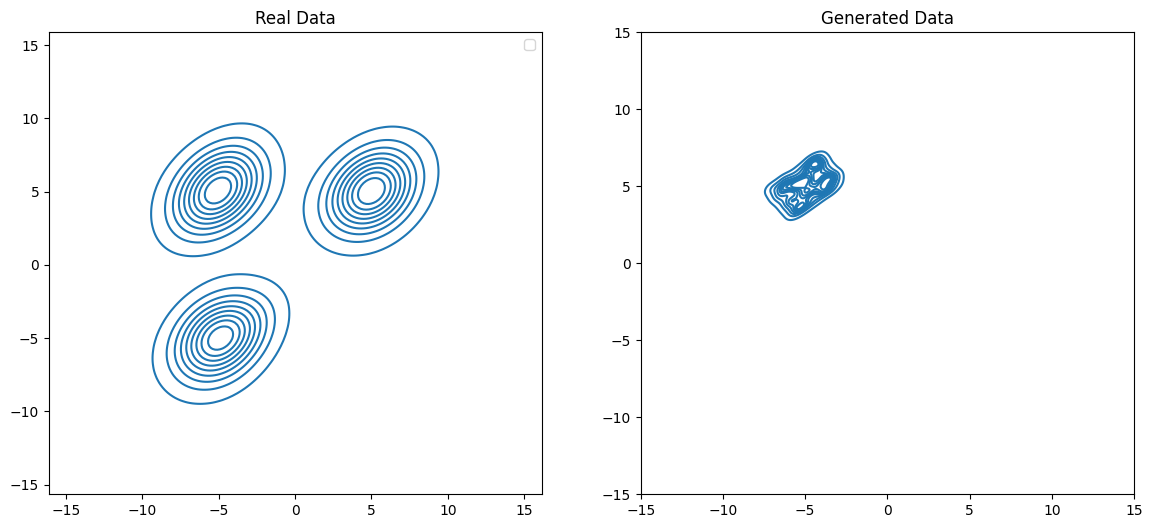

KeyboardInterrupt: 

In [ ]:
N_DISC_OPERTAIONS=50 # No of updates for discriminator on each iteration

BATCH_SIZE=64

for i in range(10000):
  for _ in range(N_DISC_OPERTAIONS):
    update_D(BATCH_SIZE)

  update_G(BATCH_SIZE)

  if i%300 == 0:
    clear_output(True)
    plt.figure(figsize=[14,6])
    plt.subplot(1,2,1)
    plt.title('Real Data')
    plot_2D_density(sample_real_data(1000).data.numpy())
    plt.legend()

    plt.subplot(1,2,2)
    plt.title('Generated Data')
    plot_2D_density(gen(generate_uniform_noise(1000)).data.numpy())

    axes=plt.gca()
    axes.set_ylim([-15,15])
    axes.set_xlim([-15,15])

    #plt.legend()
    plt.show()


Here we see that Generator is only producing data cenetered at -5,5 and not all data i.e. the three gaussian patterns. This is termed as Mode Collapse.

Mode collapse in Generative Adversarial Networks (GANs) can be linked to a talented artist who creates a popular artwork. After the work gains popularisation, the artist may be afraid to take risks and start producing similar works. This can lead to a lack of artistic exploration and eventually bore the audience.

Similarly, in GANs, mode collapse happens when the generator focuses on producing a limited set of data patterns that deceive the discriminator. It becomes fixated on a few dominant modes in the training data and fails to capture the full diversity of the data distribution.